In [52]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
import scipy.io as sio
from scipy.misc import imread
import tensorflow as tf
import numpy as np
import pandas as pd
import scipy.io
import tqdm 
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from xgboost import XGBClassifier
import random
from numpy.random import choice
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_curve
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
data_folder = 'K:\\sdp_dataset\\GPDSSyntheticSignatures4k\\bmgnet_features'

In [3]:
user_kernel='rbf'

In [4]:
data_f = pd.read_csv(os.path.join(data_folder,'data_features.csv'))
visual_f = pd.read_csv(os.path.join(data_folder,'visual_features.csv'))

# MODEL SELECTION & TRAINING

In [5]:
dev_exp_ratio = 0.30
sorted_id_list = np.sort(data_f['user_id'].unique())
dev_exp_splitter=int(len(sorted_id_list)*dev_exp_ratio)
dev_val_user_ids = sorted_id_list[:dev_exp_splitter]
exp_user_ids = sorted_id_list[dev_exp_splitter:]

In [6]:
dev_val_user_ids.shape

(1200,)

In [7]:
exp_user_ids.shape

(2800,)

In [8]:
fakes_preds = []
gens_preds = []

for fold in np.arange(0,10):
    # assert len(dev_val_user_ids)==581
    np.random.shuffle(dev_val_user_ids)
    dev_user_ids = dev_val_user_ids[0:1000]
    validation_user_ids = dev_val_user_ids[1000:len(dev_val_user_ids)]
    train_idx, test_idx = train_test_split(np.arange(1,25), train_size=0.5, test_size=0.5)

    dev_df = data_f.loc[data_f['user_id'].isin(dev_user_ids)]
    dev_vf = visual_f.loc[dev_df.index]
    val_df = data_f.loc[data_f['user_id'].isin(validation_user_ids)]
    val_vf = visual_f.loc[val_df.index]

    dev_df_gen = dev_df.loc[dev_df['fakeness']==0]
    dev_df_fake = dev_df.loc[dev_df['fakeness']==1]
    dev_df_gen_12 = dev_df_gen.loc[dev_df_gen['sig_id'].isin(train_idx)]
    dev_df_valid_12 = dev_df_gen.loc[dev_df_gen['sig_id'].isin(test_idx)]
    
    train_idx, test_idx = train_test_split(np.arange(1,25), train_size=0.5)
    val_df_gen = val_df.loc[val_df['fakeness']==0]
    val_df_fake = val_df.loc[val_df['fakeness']==1]
    val_df_gen_12 = val_df_gen.loc[val_df_gen['sig_id'].isin(train_idx)]
    val_df_valid_gen_12 = val_df_gen.loc[val_df_gen['sig_id'].isin(test_idx)]

    for user_id in tqdm.tqdm(validation_user_ids, ascii=True):
        clf = SVC(C=1,gamma='scale',class_weight='balanced', probability=False, kernel=user_kernel)
        y_train = (pd.concat([val_df_gen_12.loc[val_df_gen_12['user_id']==user_id],dev_df_gen.loc[dev_df_gen['user_id']!=user_id]]))['user_id']==user_id
        X_train = visual_f.loc[y_train.index]  
        clf.fit(X_train, y_train)
        y_valid_fakes = val_df_fake.loc[(val_df_fake['user_id']==user_id)]
        X_valid_f = visual_f.loc[y_valid_fakes.index]
        fakes_preds.append(clf.decision_function(X_valid_f))
        y_valid_gens = val_df_valid_gen_12.loc[val_df_valid_gen_12['user_id']==user_id]
        X_valid_g = visual_f.loc[y_valid_gens.index]
        gens_preds.append(clf.decision_function(X_valid_g))

c:\users\mert\anaconda3\envs\ml_gpu\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
100%|################################################################################| 200/200 [17:23<00:00,  5.91s/it]
c:\users\mert\anaconda3\envs\ml_gpu\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
100%|################################################################################| 200/200 [17:23<00:00,  5.76s/it]
c:\users\mert\anaconda3\envs\ml_gpu\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
100%|################################################################################| 200/200 [17:24<00:00,  5.

# GLOBAL THRESHOLD SELECTION

In [9]:
flat_fakes_preds = np.expand_dims(np.array([item for sublist in fakes_preds for item in sublist]),axis=1)
flat_gens_preds = np.expand_dims(np.array([item for sublist in gens_preds for item in sublist]),axis=1)
all_preds = np.vstack((flat_fakes_preds,flat_gens_preds))
all_labels = np.vstack((np.zeros((flat_fakes_preds.shape[0],1)),np.ones((flat_gens_preds.shape[0],1))))

fpr,tpr,threshold = roc_curve(all_labels,all_preds)
fnr = 1 - tpr
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
eer_th = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
print('EER_glob : ', EER*100,'\nEER_Threshold_glob : ', eer_th)
glob_th = eer_th

EER_glob :  7.003333333333334 
EER_Threshold_glob :  0.0690906672303142


In [10]:
assert len(fakes_preds)==len(gens_preds)
EER_accum=0
for idx,val in enumerate(fakes_preds):
    user_fakes_preds = np.expand_dims(np.array(fakes_preds[idx]),axis=1)
    user_gens_preds = np.expand_dims(np.array(gens_preds[idx]),axis=1)
    all_user_preds = np.vstack((user_fakes_preds,user_gens_preds))
    all_user_labels = np.vstack((np.zeros((user_fakes_preds.shape[0],1)),np.ones((user_gens_preds.shape[0],1)))) 
    fpr,tpr,threshold = roc_curve(all_user_labels,all_user_preds)
    fnr = 1 - tpr
    EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    EER_accum += EER
    
print('EER_user : ', (EER_accum*100)/len(fakes_preds)) 

EER_user :  3.335000000000005


In [11]:
print(glob_th)

0.0690906672303142


# TRAIN AND TEST ON THE EXPLOITATION SET

In [45]:
FRR_list = []
FARskilled_list = []
EERglob_list = []
EERuser_list = []
exp_user_ids = exp_user_ids[0:100]
for inverse_sample_count in np.arange(0,14):
    test_gens_preds = []
    test_fakes_preds = []

    train_idx, test_idx = train_test_split(np.arange(1,25), train_size=0.584)
    exp_df = data_f.loc[data_f['user_id'].isin(exp_user_ids)]
    exp_vf = visual_f.loc[exp_df.index]
    exp_df_gen = exp_df.loc[exp_df['fakeness']==0]
    exp_df_fake = exp_df.loc[exp_df['fakeness']==1]
    exp_df_fake_10 = exp_df_fake.loc[exp_df_fake['sig_id'].isin(choice(np.arange(1,31),10,replace=False))]
    if (inverse_sample_count == 0): 
        exp_df_gen_12 = exp_df_gen.loc[exp_df_gen['sig_id'].isin(train_idx[:])]
    else:
        exp_df_gen_12 = exp_df_gen.loc[exp_df_gen['sig_id'].isin(train_idx[:-inverse_sample_count])]
    exp_df_valid_gen_10 = exp_df_gen.loc[exp_df_gen['sig_id'].isin(test_idx[0:10])]

    dev_val_df = data_f.loc[data_f['user_id'].isin(dev_val_user_ids)]
    dev_val_vf = visual_f.loc[dev_val_df.index]
    dev_val_df_gen = dev_val_df.loc[dev_val_df['fakeness']==0]
    dev_val_df_valid_gen_14 = dev_val_df_gen.loc[dev_val_df_gen['sig_id'].isin(choice(np.arange(1,25),14,replace=False))]
    for user_id in tqdm.tqdm(exp_user_ids, ascii=True):
        clf = SVC(C=1,gamma='scale',class_weight='balanced', probability=False, kernel=user_kernel)
        y_train = (pd.concat([exp_df_gen_12.loc[exp_df_gen_12['user_id']==user_id],dev_val_df_valid_gen_14.loc[dev_val_df_valid_gen_14['user_id']!=user_id]]))['user_id']==user_id
        X_train = visual_f.loc[y_train.index]  
        clf.fit(X_train, y_train)
        y_valid_fakes = exp_df_fake_10.loc[(exp_df_fake_10['user_id']==user_id)]
        X_valid_f = visual_f.loc[y_valid_fakes.index]
        test_fakes_preds.append(clf.decision_function(X_valid_f))
        y_valid_gens = exp_df_valid_gen_10.loc[exp_df_valid_gen_10['user_id']==user_id]
        X_valid_g = visual_f.loc[y_valid_gens.index]
        test_gens_preds.append(clf.decision_function(X_valid_g))
    flat_test_fakes_preds = np.expand_dims(np.array([item for sublist in test_fakes_preds for item in sublist]),axis=1)
    flat_test_gens_preds = np.expand_dims(np.array([item for sublist in test_gens_preds for item in sublist]),axis=1)
    print("____At the EER threshold decided on the Validation set at ", 14-inverse_sample_count, " samples____")
    print("FRR at", 14-inverse_sample_count, 'samples:',(1-len(flat_test_gens_preds[flat_test_gens_preds>=glob_th])/len(flat_test_gens_preds))*100)
    FRR_list.append((1-len(flat_test_gens_preds[flat_test_gens_preds>=glob_th])/len(flat_test_gens_preds))*100)
    print("FARskilled at", 14-inverse_sample_count, 'samples:',(1-len(flat_test_fakes_preds[flat_test_fakes_preds<glob_th])/len(flat_test_fakes_preds))*100)
    FARskilled_list.append((1-len(flat_test_fakes_preds[flat_test_fakes_preds<glob_th])/len(flat_test_fakes_preds))*100)
    all_test_preds = np.vstack((flat_test_fakes_preds,flat_test_gens_preds))
    all_test_labels = np.vstack((np.zeros((flat_test_fakes_preds.shape[0],1)),np.ones((flat_test_gens_preds.shape[0],1))))

    fpr,tpr,threshold = roc_curve(all_test_labels,all_test_preds)
    fnr = 1 - tpr
    EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    eer_th = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
    print('EER_glob for test set at', 14-inverse_sample_count, 'samples:', EER*100,'\nEER_Threshold_glob for test set at', 14-inverse_sample_count, 'samples:', eer_th)
    EERglob_list.append(EER*100)
    assert len(test_fakes_preds)==len(test_gens_preds)
    EER_accum=0
    for idx,val in enumerate(test_fakes_preds):
        user_test_fakes_preds = np.expand_dims(np.array(test_fakes_preds[idx]),axis=1)
        user_test_gens_preds = np.expand_dims(np.array(test_gens_preds[idx]),axis=1)
        all_user_test_preds = np.vstack((user_test_fakes_preds,user_test_gens_preds))
        all_user_test_labels = np.vstack((np.zeros((user_test_fakes_preds.shape[0],1)),np.ones((user_test_gens_preds.shape[0],1)))) 
        fpr,tpr,threshold = roc_curve(all_user_test_labels,all_user_test_preds)
        fnr = 1 - tpr
        EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
        EER_accum += EER

    print('EER_user for test set at', 14-inverse_sample_count, 'samples:', (EER_accum*100)/len(test_fakes_preds))
    EERuser_list.append((EER_accum*100)/len(test_fakes_preds))

c:\users\mert\anaconda3\envs\ml_gpu\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)








  0%|                                                                                          | 0/100 [00:00<?, ?it/s]







  1%|8                                                                                 | 1/100 [00:03<05:22,  3.26s/it]







  2%|#6                                                                                | 2/100 [00:06<05:14,  3.21s/it]







  3%|##4                                                                               | 3/100 [00:10<05:35,  3.45s/it]







  4%|###2                                                                              | 4/100 [00:14<05:47,  3.62s/it]







  5%|####1                                                                             | 5/100 [00:16<05:11,  3.27s/it]







  6%|####9    

 62%|##################################################2                              | 62/100 [03:29<02:02,  3.23s/it]







 63%|###################################################                              | 63/100 [03:32<01:57,  3.17s/it]







 64%|###################################################8                             | 64/100 [03:35<01:53,  3.14s/it]







 65%|####################################################6                            | 65/100 [03:39<01:52,  3.22s/it]







 66%|#####################################################4                           | 66/100 [03:42<01:52,  3.32s/it]







 67%|######################################################2                          | 67/100 [03:46<01:52,  3.41s/it]







 68%|#######################################################                          | 68/100 [03:50<01:51,  3.47s/it]







 69%|#######################################################8                         | 69/100 [03:53<01:45,  3

____At the EER threshold decided on the Validation set at  14  samples____
FRR at 14 samples: 2.9000000000000026
FARskilled at 14 samples: 8.099999999999996
EER_glob for test set at 14 samples: 5.8999999999999995 
EER_Threshold_glob for test set at 14 samples: 0.21773940772238687
EER_user for test set at 14 samples: 2.600000000000001


c:\users\mert\anaconda3\envs\ml_gpu\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)








  0%|                                                                                          | 0/100 [00:00<?, ?it/s]







  1%|8                                                                                 | 1/100 [00:03<05:08,  3.11s/it]







  2%|#6                                                                                | 2/100 [00:06<05:00,  3.07s/it]







  3%|##4                                                                               | 3/100 [00:09<05:18,  3.29s/it]







  4%|###2                                                                              | 4/100 [00:13<05:35,  3.49s/it]







  5%|####1                                                                             | 5/100 [00:16<04:59,  3.15s/it]







  6%|####9    

 62%|##################################################2                              | 62/100 [03:28<02:01,  3.20s/it]







 63%|###################################################                              | 63/100 [03:31<01:56,  3.15s/it]







 64%|###################################################8                             | 64/100 [03:34<01:52,  3.13s/it]







 65%|####################################################6                            | 65/100 [03:38<01:56,  3.32s/it]







 66%|#####################################################4                           | 66/100 [03:42<01:56,  3.41s/it]







 67%|######################################################2                          | 67/100 [03:45<01:53,  3.44s/it]







 68%|#######################################################                          | 68/100 [03:49<01:49,  3.41s/it]







 69%|#######################################################8                         | 69/100 [03:52<01:44,  3

____At the EER threshold decided on the Validation set at  13  samples____
FRR at 13 samples: 4.0000000000000036
FARskilled at 13 samples: 8.599999999999996
EER_glob for test set at 13 samples: 6.4 
EER_Threshold_glob for test set at 13 samples: 0.22620332499717866
EER_user for test set at 13 samples: 2.2000000000000006


c:\users\mert\anaconda3\envs\ml_gpu\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)








  0%|                                                                                          | 0/100 [00:00<?, ?it/s]







  1%|8                                                                                 | 1/100 [00:03<05:43,  3.47s/it]







  2%|#6                                                                                | 2/100 [00:06<05:20,  3.27s/it]







  3%|##4                                                                               | 3/100 [00:10<05:31,  3.42s/it]







  4%|###2                                                                              | 4/100 [00:14<05:52,  3.68s/it]







  5%|####1                                                                             | 5/100 [00:16<05:11,  3.28s/it]







  6%|####9    

 62%|##################################################2                              | 62/100 [03:25<02:00,  3.17s/it]







 63%|###################################################                              | 63/100 [03:28<01:55,  3.12s/it]







 64%|###################################################8                             | 64/100 [03:31<01:52,  3.13s/it]







 65%|####################################################6                            | 65/100 [03:35<01:57,  3.35s/it]







 66%|#####################################################4                           | 66/100 [03:39<01:56,  3.43s/it]







 67%|######################################################2                          | 67/100 [03:42<01:54,  3.47s/it]







 68%|#######################################################                          | 68/100 [03:46<01:52,  3.50s/it]







 69%|#######################################################8                         | 69/100 [03:49<01:42,  3

____At the EER threshold decided on the Validation set at  12  samples____
FRR at 12 samples: 4.0000000000000036
FARskilled at 12 samples: 8.399999999999997
EER_glob for test set at 12 samples: 6.7 
EER_Threshold_glob for test set at 12 samples: 0.16907095378769998
EER_user for test set at 12 samples: 2.9000000000000012


c:\users\mert\anaconda3\envs\ml_gpu\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)








  0%|                                                                                          | 0/100 [00:00<?, ?it/s]







  1%|8                                                                                 | 1/100 [00:03<05:32,  3.36s/it]







  2%|#6                                                                                | 2/100 [00:06<05:16,  3.23s/it]







  3%|##4                                                                               | 3/100 [00:10<05:33,  3.44s/it]







  4%|###2                                                                              | 4/100 [00:13<05:38,  3.52s/it]







  5%|####1                                                                             | 5/100 [00:16<05:05,  3.22s/it]







  6%|####9    

 62%|##################################################2                              | 62/100 [03:22<02:01,  3.19s/it]







 63%|###################################################                              | 63/100 [03:24<01:53,  3.07s/it]







 64%|###################################################8                             | 64/100 [03:28<01:53,  3.17s/it]







 65%|####################################################6                            | 65/100 [03:31<01:51,  3.19s/it]







 66%|#####################################################4                           | 66/100 [03:34<01:49,  3.21s/it]







 67%|######################################################2                          | 67/100 [03:38<01:50,  3.35s/it]







 68%|#######################################################                          | 68/100 [03:41<01:47,  3.35s/it]







 69%|#######################################################8                         | 69/100 [03:45<01:44,  3

____At the EER threshold decided on the Validation set at  11  samples____
FRR at 11 samples: 4.400000000000004
FARskilled at 11 samples: 8.099999999999996
EER_glob for test set at 11 samples: 7.000000000000001 
EER_Threshold_glob for test set at 11 samples: 0.14363044548124781
EER_user for test set at 11 samples: 2.600000000000001


c:\users\mert\anaconda3\envs\ml_gpu\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)








  0%|                                                                                          | 0/100 [00:00<?, ?it/s]







  1%|8                                                                                 | 1/100 [00:03<05:20,  3.24s/it]







  2%|#6                                                                                | 2/100 [00:06<05:10,  3.16s/it]







  3%|##4                                                                               | 3/100 [00:09<05:18,  3.28s/it]







  4%|###2                                                                              | 4/100 [00:13<05:30,  3.44s/it]







  5%|####1                                                                             | 5/100 [00:15<04:56,  3.12s/it]







  6%|####9    

 62%|##################################################2                              | 62/100 [03:17<01:55,  3.03s/it]







 63%|###################################################                              | 63/100 [03:20<01:49,  2.97s/it]







 64%|###################################################8                             | 64/100 [03:23<01:49,  3.05s/it]







 65%|####################################################6                            | 65/100 [03:27<01:52,  3.23s/it]







 66%|#####################################################4                           | 66/100 [03:31<01:52,  3.32s/it]







 67%|######################################################2                          | 67/100 [03:34<01:48,  3.29s/it]







 68%|#######################################################                          | 68/100 [03:37<01:46,  3.34s/it]







 69%|#######################################################8                         | 69/100 [03:41<01:44,  3

____At the EER threshold decided on the Validation set at  10  samples____
FRR at 10 samples: 4.800000000000004
FARskilled at 10 samples: 7.699999999999996
EER_glob for test set at 10 samples: 6.7 
EER_Threshold_glob for test set at 10 samples: 0.1338460540077704
EER_user for test set at 10 samples: 2.400000000000001


c:\users\mert\anaconda3\envs\ml_gpu\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)








  0%|                                                                                          | 0/100 [00:00<?, ?it/s]







  1%|8                                                                                 | 1/100 [00:03<05:32,  3.35s/it]







  2%|#6                                                                                | 2/100 [00:06<05:11,  3.18s/it]







  3%|##4                                                                               | 3/100 [00:09<05:26,  3.36s/it]







  4%|###2                                                                              | 4/100 [00:13<05:34,  3.49s/it]







  5%|####1                                                                             | 5/100 [00:16<05:04,  3.21s/it]







  6%|####9    

 62%|##################################################2                              | 62/100 [03:16<01:50,  2.92s/it]







 63%|###################################################                              | 63/100 [03:19<01:47,  2.91s/it]







 64%|###################################################8                             | 64/100 [03:22<01:46,  2.94s/it]







 65%|####################################################6                            | 65/100 [03:25<01:46,  3.04s/it]







 66%|#####################################################4                           | 66/100 [03:28<01:43,  3.03s/it]







 67%|######################################################2                          | 67/100 [03:31<01:41,  3.08s/it]







 68%|#######################################################                          | 68/100 [03:34<01:39,  3.12s/it]







 69%|#######################################################8                         | 69/100 [03:38<01:38,  3

____At the EER threshold decided on the Validation set at  9  samples____
FRR at 9 samples: 6.2999999999999945
FARskilled at 9 samples: 8.199999999999996
EER_glob for test set at 9 samples: 7.3 
EER_Threshold_glob for test set at 9 samples: 0.11952089359878149
EER_user for test set at 9 samples: 2.700000000000001


c:\users\mert\anaconda3\envs\ml_gpu\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)








  0%|                                                                                          | 0/100 [00:00<?, ?it/s]







  1%|8                                                                                 | 1/100 [00:03<05:02,  3.05s/it]







  2%|#6                                                                                | 2/100 [00:05<04:52,  2.98s/it]







  3%|##4                                                                               | 3/100 [00:09<04:54,  3.04s/it]







  4%|###2                                                                              | 4/100 [00:12<05:00,  3.13s/it]







  5%|####1                                                                             | 5/100 [00:14<04:42,  2.97s/it]







  6%|####9    

 62%|##################################################2                              | 62/100 [03:11<01:52,  2.96s/it]







 63%|###################################################                              | 63/100 [03:14<01:45,  2.85s/it]







 64%|###################################################8                             | 64/100 [03:17<01:47,  2.98s/it]







 65%|####################################################6                            | 65/100 [03:21<01:52,  3.22s/it]







 66%|#####################################################4                           | 66/100 [03:24<01:48,  3.19s/it]







 67%|######################################################2                          | 67/100 [03:27<01:44,  3.15s/it]







 68%|#######################################################                          | 68/100 [03:31<01:43,  3.23s/it]







 69%|#######################################################8                         | 69/100 [03:33<01:37,  3

____At the EER threshold decided on the Validation set at  8  samples____
FRR at 8 samples: 7.799999999999995
FARskilled at 8 samples: 7.199999999999996
EER_glob for test set at 8 samples: 7.199999999999999 
EER_Threshold_glob for test set at 8 samples: 0.06358951976905192
EER_user for test set at 8 samples: 2.5000000000000013


c:\users\mert\anaconda3\envs\ml_gpu\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)








  0%|                                                                                          | 0/100 [00:00<?, ?it/s]







  1%|8                                                                                 | 1/100 [00:03<04:58,  3.02s/it]







  2%|#6                                                                                | 2/100 [00:05<04:53,  3.00s/it]







  3%|##4                                                                               | 3/100 [00:09<04:55,  3.05s/it]







  4%|###2                                                                              | 4/100 [00:12<05:12,  3.26s/it]







  5%|####1                                                                             | 5/100 [00:15<04:47,  3.02s/it]







  6%|####9    

 62%|##################################################2                              | 62/100 [03:09<01:52,  2.95s/it]







 63%|###################################################                              | 63/100 [03:11<01:47,  2.90s/it]







 64%|###################################################8                             | 64/100 [03:14<01:44,  2.89s/it]







 65%|####################################################6                            | 65/100 [03:17<01:43,  2.97s/it]







 66%|#####################################################4                           | 66/100 [03:20<01:41,  2.99s/it]







 67%|######################################################2                          | 67/100 [03:23<01:38,  2.98s/it]







 68%|#######################################################                          | 68/100 [03:27<01:37,  3.05s/it]







 69%|#######################################################8                         | 69/100 [03:30<01:34,  3

____At the EER threshold decided on the Validation set at  7  samples____
FRR at 7 samples: 8.999999999999996
FARskilled at 7 samples: 7.199999999999996
EER_glob for test set at 7 samples: 7.5 
EER_Threshold_glob for test set at 7 samples: 0.037367497972160546
EER_user for test set at 7 samples: 2.800000000000001


c:\users\mert\anaconda3\envs\ml_gpu\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)








  0%|                                                                                          | 0/100 [00:00<?, ?it/s]







  1%|8                                                                                 | 1/100 [00:03<05:34,  3.38s/it]







  2%|#6                                                                                | 2/100 [00:06<05:16,  3.23s/it]







  3%|##4                                                                               | 3/100 [00:09<05:05,  3.15s/it]







  4%|###2                                                                              | 4/100 [00:12<05:16,  3.30s/it]







  5%|####1                                                                             | 5/100 [00:14<04:38,  2.93s/it]







  6%|####9    

 62%|##################################################2                              | 62/100 [03:03<01:46,  2.80s/it]







 63%|###################################################                              | 63/100 [03:06<01:40,  2.71s/it]







 64%|###################################################8                             | 64/100 [03:09<01:41,  2.81s/it]







 65%|####################################################6                            | 65/100 [03:12<01:41,  2.91s/it]







 66%|#####################################################4                           | 66/100 [03:15<01:40,  2.95s/it]







 67%|######################################################2                          | 67/100 [03:18<01:36,  2.92s/it]







 68%|#######################################################                          | 68/100 [03:21<01:35,  2.99s/it]







 69%|#######################################################8                         | 69/100 [03:24<01:32,  2

____At the EER threshold decided on the Validation set at  6  samples____
FRR at 6 samples: 12.3
FARskilled at 6 samples: 6.999999999999995
EER_glob for test set at 6 samples: 8.1 
EER_Threshold_glob for test set at 6 samples: -0.03670566886289395
EER_user for test set at 6 samples: 2.800000000000001


c:\users\mert\anaconda3\envs\ml_gpu\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)








  0%|                                                                                          | 0/100 [00:00<?, ?it/s]







  1%|8                                                                                 | 1/100 [00:02<04:39,  2.82s/it]







  2%|#6                                                                                | 2/100 [00:05<04:36,  2.82s/it]







  3%|##4                                                                               | 3/100 [00:08<04:38,  2.87s/it]







  4%|###2                                                                              | 4/100 [00:12<04:52,  3.05s/it]







  5%|####1                                                                             | 5/100 [00:14<04:31,  2.86s/it]







  6%|####9    

 62%|##################################################2                              | 62/100 [03:00<01:45,  2.77s/it]







 63%|###################################################                              | 63/100 [03:03<01:43,  2.80s/it]







 64%|###################################################8                             | 64/100 [03:05<01:39,  2.77s/it]







 65%|####################################################6                            | 65/100 [03:09<01:42,  2.92s/it]







 66%|#####################################################4                           | 66/100 [03:12<01:39,  2.94s/it]







 67%|######################################################2                          | 67/100 [03:15<01:37,  2.96s/it]







 68%|#######################################################                          | 68/100 [03:18<01:36,  3.03s/it]







 69%|#######################################################8                         | 69/100 [03:21<01:33,  3

____At the EER threshold decided on the Validation set at  5  samples____
FRR at 5 samples: 16.300000000000004
FARskilled at 5 samples: 6.2000000000000055
EER_glob for test set at 5 samples: 9.0 
EER_Threshold_glob for test set at 5 samples: -0.11247903341677778
EER_user for test set at 5 samples: 2.9000000000000012


c:\users\mert\anaconda3\envs\ml_gpu\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)








  0%|                                                                                          | 0/100 [00:00<?, ?it/s]







  1%|8                                                                                 | 1/100 [00:03<04:57,  3.00s/it]







  2%|#6                                                                                | 2/100 [00:05<04:46,  2.93s/it]







  3%|##4                                                                               | 3/100 [00:09<04:56,  3.06s/it]







  4%|###2                                                                              | 4/100 [00:12<04:51,  3.03s/it]







  5%|####1                                                                             | 5/100 [00:14<04:26,  2.80s/it]







  6%|####9    

 62%|##################################################2                              | 62/100 [02:54<01:47,  2.82s/it]







 63%|###################################################                              | 63/100 [02:56<01:40,  2.72s/it]







 64%|###################################################8                             | 64/100 [02:59<01:39,  2.77s/it]







 65%|####################################################6                            | 65/100 [03:02<01:34,  2.69s/it]







 66%|#####################################################4                           | 66/100 [03:05<01:37,  2.87s/it]







 67%|######################################################2                          | 67/100 [03:08<01:35,  2.89s/it]







 68%|#######################################################                          | 68/100 [03:11<01:31,  2.85s/it]







 69%|#######################################################8                         | 69/100 [03:13<01:25,  2

____At the EER threshold decided on the Validation set at  4  samples____
FRR at 4 samples: 20.799999999999997
FARskilled at 4 samples: 5.000000000000004
EER_glob for test set at 4 samples: 9.0 
EER_Threshold_glob for test set at 4 samples: -0.18276614338543173
EER_user for test set at 4 samples: 3.1000000000000005


c:\users\mert\anaconda3\envs\ml_gpu\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)








  0%|                                                                                          | 0/100 [00:00<?, ?it/s]







  1%|8                                                                                 | 1/100 [00:02<04:17,  2.60s/it]







  2%|#6                                                                                | 2/100 [00:05<04:24,  2.70s/it]







  3%|##4                                                                               | 3/100 [00:08<04:31,  2.80s/it]







  4%|###2                                                                              | 4/100 [00:12<04:51,  3.03s/it]







  5%|####1                                                                             | 5/100 [00:14<04:25,  2.80s/it]







  6%|####9    

 62%|##################################################2                              | 62/100 [02:49<01:41,  2.67s/it]







 63%|###################################################                              | 63/100 [02:52<01:32,  2.50s/it]







 64%|###################################################8                             | 64/100 [02:54<01:31,  2.55s/it]







 65%|####################################################6                            | 65/100 [02:57<01:30,  2.58s/it]







 66%|#####################################################4                           | 66/100 [03:00<01:28,  2.61s/it]







 67%|######################################################2                          | 67/100 [03:02<01:26,  2.63s/it]







 68%|#######################################################                          | 68/100 [03:05<01:25,  2.67s/it]







 69%|#######################################################8                         | 69/100 [03:08<01:23,  2

____At the EER threshold decided on the Validation set at  3  samples____
FRR at 3 samples: 31.000000000000007
FARskilled at 3 samples: 5.100000000000005
EER_glob for test set at 3 samples: 11.4 
EER_Threshold_glob for test set at 3 samples: -0.2832078503805533
EER_user for test set at 3 samples: 3.9000000000000017


c:\users\mert\anaconda3\envs\ml_gpu\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)








  0%|                                                                                          | 0/100 [00:00<?, ?it/s]







  1%|8                                                                                 | 1/100 [00:02<03:53,  2.36s/it]







  2%|#6                                                                                | 2/100 [00:04<03:55,  2.40s/it]







  3%|##4                                                                               | 3/100 [00:07<04:05,  2.53s/it]







  4%|###2                                                                              | 4/100 [00:10<04:06,  2.57s/it]







  5%|####1                                                                             | 5/100 [00:12<03:52,  2.45s/it]







  6%|####9    

 62%|##################################################2                              | 62/100 [02:39<01:40,  2.63s/it]







 63%|###################################################                              | 63/100 [02:41<01:33,  2.52s/it]







 64%|###################################################8                             | 64/100 [02:43<01:26,  2.40s/it]







 65%|####################################################6                            | 65/100 [02:46<01:33,  2.67s/it]







 66%|#####################################################4                           | 66/100 [02:49<01:29,  2.62s/it]







 67%|######################################################2                          | 67/100 [02:52<01:27,  2.64s/it]







 68%|#######################################################                          | 68/100 [02:54<01:25,  2.66s/it]







 69%|#######################################################8                         | 69/100 [02:57<01:21,  2

____At the EER threshold decided on the Validation set at  2  samples____
FRR at 2 samples: 48.6
FARskilled at 2 samples: 3.7000000000000033
EER_glob for test set at 2 samples: 12.6 
EER_Threshold_glob for test set at 2 samples: -0.451440931411353
EER_user for test set at 2 samples: 4.600000000000001


c:\users\mert\anaconda3\envs\ml_gpu\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)








  0%|                                                                                          | 0/100 [00:00<?, ?it/s]







  1%|8                                                                                 | 1/100 [00:02<03:24,  2.07s/it]







  2%|#6                                                                                | 2/100 [00:04<03:44,  2.29s/it]







  3%|##4                                                                               | 3/100 [00:07<03:39,  2.27s/it]







  4%|###2                                                                              | 4/100 [00:09<03:46,  2.36s/it]







  5%|####1                                                                             | 5/100 [00:11<03:41,  2.33s/it]







  6%|####9    

 62%|##################################################2                              | 62/100 [02:23<01:20,  2.12s/it]







 63%|###################################################                              | 63/100 [02:25<01:16,  2.06s/it]







 64%|###################################################8                             | 64/100 [02:27<01:15,  2.09s/it]







 65%|####################################################6                            | 65/100 [02:30<01:18,  2.23s/it]







 66%|#####################################################4                           | 66/100 [02:32<01:14,  2.19s/it]







 67%|######################################################2                          | 67/100 [02:34<01:15,  2.29s/it]







 68%|#######################################################                          | 68/100 [02:37<01:17,  2.42s/it]







 69%|#######################################################8                         | 69/100 [02:40<01:16,  2

____At the EER threshold decided on the Validation set at  1  samples____
FRR at 1 samples: 82.60000000000001
FARskilled at 1 samples: 1.5000000000000013
EER_glob for test set at 1 samples: 15.9 
EER_Threshold_glob for test set at 1 samples: -0.6699404840167547
EER_user for test set at 1 samples: 7.099999999999994


In [76]:
FRR_list

[2.9000000000000026,
 4.0000000000000036,
 4.0000000000000036,
 4.400000000000004,
 4.800000000000004,
 6.2999999999999945,
 7.799999999999995,
 8.999999999999996,
 12.3,
 16.300000000000004,
 20.799999999999997,
 31.000000000000007,
 48.6,
 82.60000000000001,
 nan]

In [77]:
FARskilled_list

[8.099999999999996,
 8.599999999999996,
 8.399999999999997,
 8.099999999999996,
 7.699999999999996,
 8.199999999999996,
 7.199999999999996,
 7.199999999999996,
 6.999999999999995,
 6.2000000000000055,
 5.000000000000004,
 5.100000000000005,
 3.7000000000000033,
 1.5000000000000013,
 nan]

In [84]:
EERglob_list

[5.8999999999999995,
 6.4,
 6.7,
 7.000000000000001,
 6.7,
 7.3,
 7.199999999999999,
 7.5,
 8.1,
 9.0,
 9.0,
 11.4,
 12.6,
 15.9,
 nan]

In [72]:
EERuser_list

[2.600000000000001,
 2.2000000000000006,
 2.9000000000000012,
 2.600000000000001,
 2.400000000000001,
 2.700000000000001,
 2.5000000000000013,
 2.800000000000001,
 2.800000000000001,
 2.9000000000000012,
 3.1000000000000005,
 3.9000000000000017,
 4.600000000000001,
 7.099999999999994,
 nan]

In [70]:
if EERglob_list[-1] != np.nan: EERglob_list.append(np.nan)
EERglob_list

[5.8999999999999995,
 6.4,
 6.7,
 7.000000000000001,
 6.7,
 7.3,
 7.199999999999999,
 7.5,
 8.1,
 9.0,
 9.0,
 11.4,
 12.6,
 15.9,
 nan]

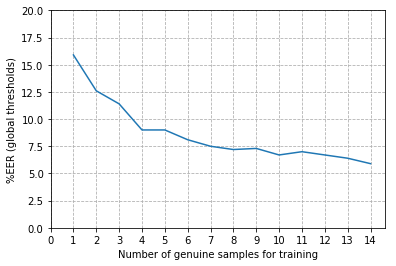

In [93]:
plt.plot(EERglob_list[::-1])
plt.ylim(0,20)
plt.ylabel('%EER (global thresholds)')
plt.xlabel('Number of genuine samples for training')
plt.xticks(np.arange(0, len(EERglob_list)))
plt.grid('on', linestyle='--')
plt.show()

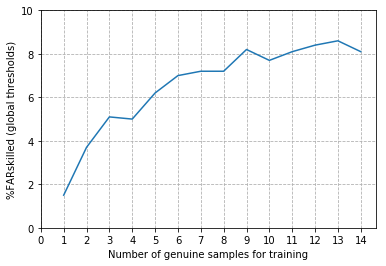

In [94]:
plt.plot(FARskilled_list[::-1])
plt.ylim(0,10)
plt.ylabel('%FARskilled (global thresholds)')
plt.xlabel('Number of genuine samples for training')
plt.xticks(np.arange(0, len(FARskilled_list)))
plt.grid('on', linestyle='--')
plt.show()

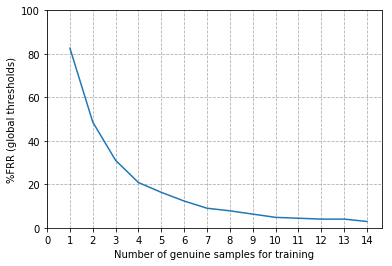

In [95]:
plt.plot(FRR_list[::-1])
plt.ylim(0,100)
plt.ylabel('%FRR (global thresholds)')
plt.xlabel('Number of genuine samples for training')
plt.xticks(np.arange(0, len(FARskilled_list)))
plt.grid('on', linestyle='--')
plt.show()

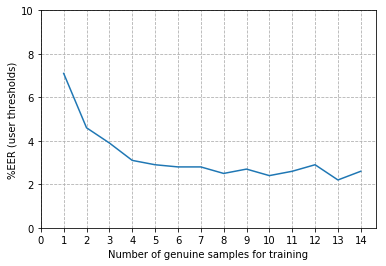

In [96]:
plt.plot(EERuser_list[::-1])
plt.ylim(0,10)
plt.ylabel('%EER (user thresholds)')
plt.xlabel('Number of genuine samples for training')
plt.xticks(np.arange(0, len(EERuser_list)))
plt.grid('on', linestyle='--')
plt.show()